---

# Exercise 2 同じデータ、異なるモデル

このコードでは、
[回帰](https://ja.wikipedia.org/wiki/%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90)と
[ニューラルネットワーク](https://ja.wikipedia.org/wiki/%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF)
を使用して、新潟県の気象データから気温を予測するモデルを作成します。

1. データの読み込みと確認
2. モデルの作成と予測値の表示
    1. (回帰モデル)各年の11月1日の数値から予測する
    2. (回帰モデル)2024年の8,9,10月の数値から予測する
    3. (NNモデル,AI)全てのデータを使用して予測する
3. モデルの比較

背景が灰色のセルはプログラムコードが記述されています。
`Shift` + `Enter` で実行してみましょう！

In [ ]:
#初期設定
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# データの読み込み

df = pd.read_csv("niigata.csv")
# df = pd.read_csv("https://www.ces-alpha.org/course/file_serve/5160388880498688/niigata.csv") # サーバーデータを直接参照する場合

df["年月日"] = pd.to_datetime(df["年月日"])
df["年"] = df["年月日"].dt.year
df["月"] = df["年月日"].dt.month
df["日"] = df["年月日"].dt.day

display(df)

新潟市の2014年1月1日～2024年11月14日までの日別平均気温のデータが読み込まれました。  

このデータを使用して、2024年11月1日の平均気温の予測をしてみましょう。

なお、実際の観測値は$16.3$℃です。

In [ ]:
sns.lineplot(data=df, x="年月日", y="平均気温")
plt.plot(df.iloc[3957,0], df.iloc[3957,1], "r", marker="o")
plt.annotate(str(df.iloc[3957, 0])+"  "+str(df.iloc[3957, 1])+"℃", 
             (df.iloc[3957, 0], df.iloc[3957, 1]), 
             textcoords="offset points", xytext=(10, 10), ha='center')
plt.show()

---
---

# 2. モデルの作成と予測値の表示

以下では、3つのモデルを作成する。

A. 各年の11月1日の数値から回帰分析で予測する  
B. 2024年の8,9,10月の数値から自己回帰分析で予測する  
C. 全てのデータを使用してAI（ニューラルネットワーク）で予測する

---
## 2-A. 各年の11月1日の数値から回帰分析で予測する

(イメージ)
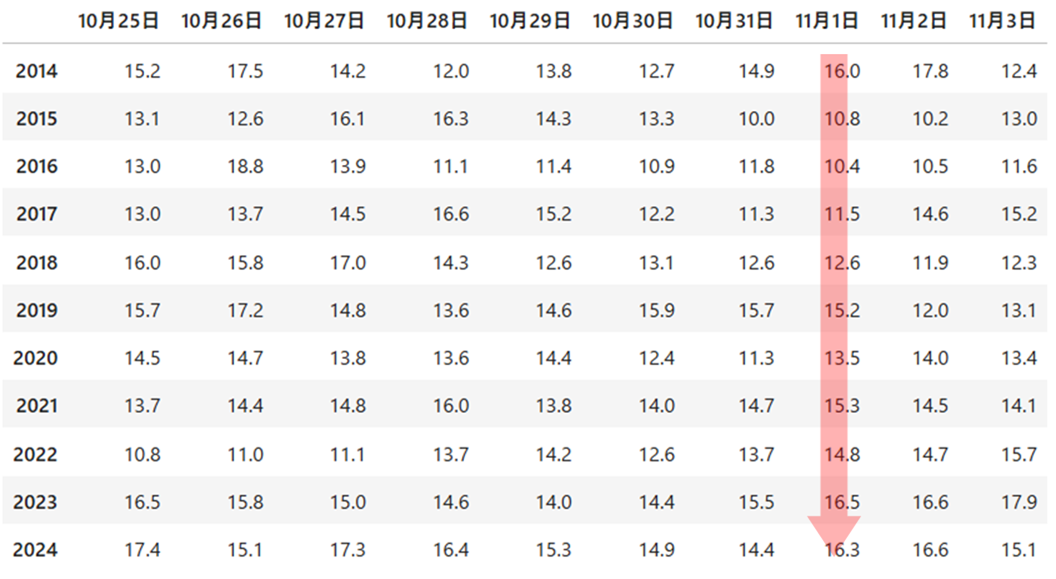

In [ ]:
df_model1 = df[(df["年"] < 2024) & (df["月"] == 11) & (df["日"] == 1)].copy()

# 過去の11月1日の数値による回帰モデル
X = df_model1["年"].values.reshape(-1,1)
Y = df_model1["平均気温"].values.reshape(-1,1)
model1 = LinearRegression()
model1.fit(X, Y)
model1_pred = model1.predict([[2024]])[0][0]

sns.regplot(data=df_model1, x="年", y="平均気温")
plt.plot(2024, df.iloc[3957,1], "r", marker="o")
plt.annotate("2024/11/1, True: "+str(df.iloc[3957, 1])+"℃", 
             (2024, df.iloc[3957, 1]), 
             textcoords="offset points", xytext=(-10, 10), ha='left')
plt.plot(2024, model1_pred, "b", marker="x")
plt.annotate("2024/11/1, Pred: "+str(round(model1_pred,3))+"℃", 
             (2024, model1_pred), 
             textcoords="offset points", xytext=(-10, -20), ha='left')
plt.show()

---
## 2-B. 2024年の8,9,10月の数値から予測する

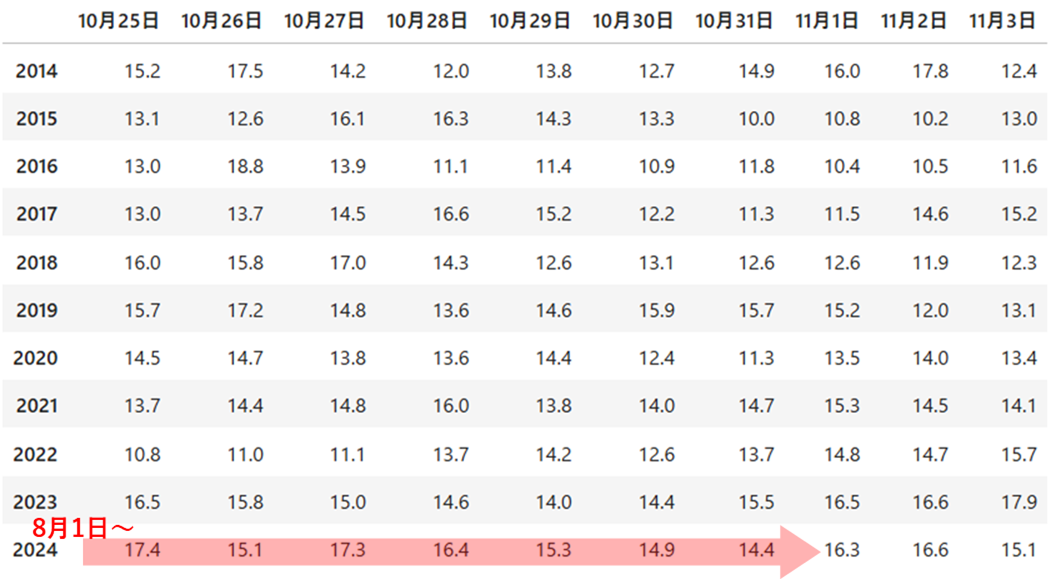

In [ ]:
df_model2 = df[(df["年"] == 2024) & (df["月"].isin([8,9,10]))].copy()
df_model2.reset_index(inplace=True, drop=True)
df_model2.reset_index(inplace=True, drop=False)
target_x = df_model2["index"].values[-1]+1

# 2024年8月1日以降の数値による回帰モデル
X = df_model2["index"].values.reshape(-1,1)
Y = df_model2["平均気温"].values.reshape(-1,1)
model2 = LinearRegression()
model2.fit(X, Y)
model2_pred = model2.predict([[target_x]])[0][0]

sns.regplot(data=df_model2, x="index", y="平均気温")
plt.plot(target_x, df.iloc[3957,1], "r", marker="o")
plt.annotate("2024/11/1, True: "+str(df.iloc[3957, 1])+"℃", 
             (target_x, df.iloc[3957, 1]), 
             textcoords="offset points", xytext=(-10, -20), ha='left')
plt.plot(target_x, model2_pred, "b", marker="x")
plt.annotate("2024/11/1, Pred: "+str(round(model2_pred,3))+"℃", 
             (target_x, model2_pred), 
             textcoords="offset points", xytext=(-10, 10), ha='left')
plt.show()

---
## 2-C. 全てのデータを使用してAI（ニューラルネットワーク）で予測する

イメージ
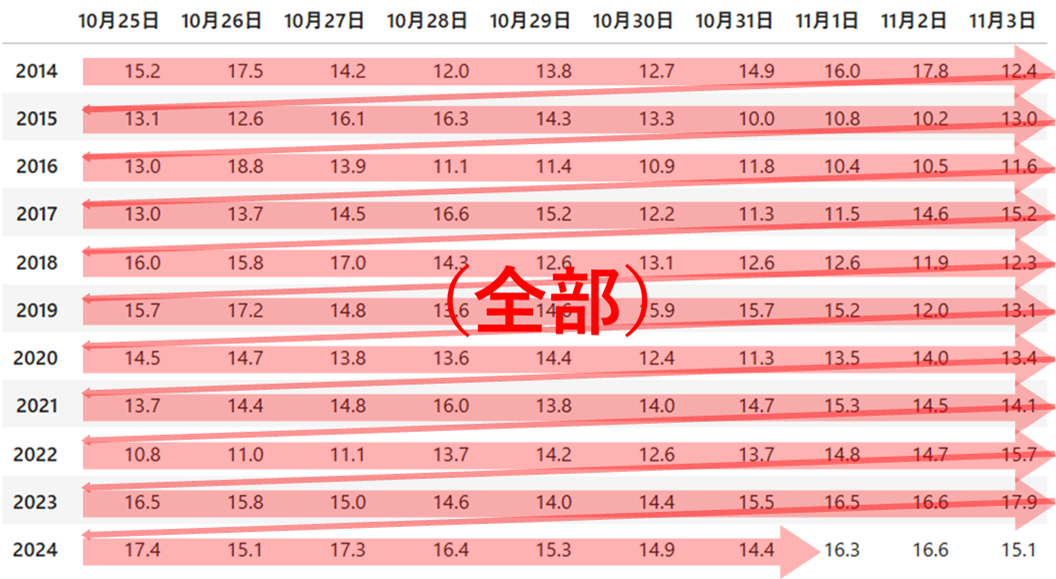

In [ ]:
import numpy as np
df_model3 = df.iloc[:3957].copy() # index 3957 is 2024/11/1.
df_model3.reset_index(inplace=True, drop=False)
target_x=df_model3[["index"]][-1:]

# # 2014年1月1日以降の数値によるニューラルネットワークモデル
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 3))
X = scaler_x.fit_transform(np.array(df_model3[:-1].index).reshape(-1,1))
Y = scaler_y.fit_transform(np.array(df_model3[["平均気温"]][:-1].values))
model3 = MLPRegressor(hidden_layer_sizes=(50, 200, 50, ), max_iter=1000, shuffle=True, random_state=42, verbose=0)
model3.fit(X, Y.ravel())

# 基データの描画
sns.lineplot(data=df_model3, x="index", y="平均気温")
plt.plot(target_x, df.iloc[3957,1], "r", marker="o")
plt.annotate("2024/11/1, True: "+str(df.iloc[3957, 1])+"℃", 
                 (target_x.values, df.iloc[3957, 1]), 
                 textcoords="offset points", xytext=(-10, 10), ha='left')

# モデルによる予測グラフの描画
preds = model3.predict(scaler_x.transform(np.array(df_model3.index).reshape(-1,1)))
df_model3["予測平均気温"] = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(-1)
model3_pred = df_model3["予測平均気温"].iloc[-1]
sns.lineplot(data=df_model3, x="index", y="予測平均気温")
plt.plot(target_x, model3_pred, "b", marker="x")
plt.annotate("2024/11/1, Pred: "+str(round(model3_pred, 2))+"℃", 
             (target_x.values, model3_pred), 
             textcoords="offset points", xytext=(-10, -10), ha='left')

plt.show()

---
## 3. モデルの比較

In [ ]:
true_value = df.iloc[3957, 1]
pred_values = np.array([model1_pred, model2_pred, model3_pred])
error_values = true_value - pred_values
summary = pd.DataFrame([pred_values, error_values],
                       columns = ["pred_model1", "pred_model2", "pred_model3"], 
                       index = ["predicton", "error"])

print("2024/11/1の平均気温実測値：", true_value)
print("2024/11/1の各モデルの予測値と誤差：")
display(summary)

---
---

### 演習
1. 最も誤差の小さかったモデルはどれだろうか？
2. `model1`と`model2`でそれぞれ誤差の方向が逆（過大評価、過小評価）になっている。理由を考察してみましょう。
4. これらの予測値はどのように解釈されるだろうか。  
   参考1：[新潟地方気象台 新潟県気象旬報](https://www.data.jma.go.jp/niigata/nogyo/nogyo_index.html)  
   参考2：[BSN_NEW_DIG 「千葉から来たんだけどこっちの方が暑い」...(2024/10/18)](https://newsdig.tbs.co.jp/articles/bsn/1497744?display=1)
5. `model3`ニューラルネットワークモデルの複雑さ`hidden_layer_sizes=(50, 200, 50, )`を適当に書き換えて、予測値の変化を観察してみましょう。
